# Reinforcement learning cryptocurrency trading bot

   <a href="https://colab.research.google.com/github/shmyak-ai/cryp-bot-demo/blob/main/CrypRLAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer:
This article is for information purposes only.
It is not intended to be investment advice. Seek a duly licensed professional for investment advice.

## Introduction

There are many paid and open source cryptocurrency trading bots on the Internet.
Most of them are not fully automated, you need to configure parameters, choose or develop a strategy, etc. in order to use them.
These bots can help users trade better, but cannot operate independently.
Another problem with these bots is that they are rule-based (or heuristic), they apply some hard-written strategies to achieve profits.
This makes them sub-optimal, since no one knows if there are better strategies or not.
There is a group of algorithms that find the optimal solution, it is called reinforcement learning.

There is no purpose to describe reinforcement algorithms in this article.
One can find a nice overview for example [here](https://lilianweng.github.io/posts/2018-02-19-rl-overview/).
In short, reinforcement learning consists of two parts:
1. Environment.
One can consider it as a function, where input parameters are actions and output parameters are a state and a reward.
For example, a crypto trading market can be an environment.
This environment at each time step receives actions from traders and produces a new state (new cryptocurrency prices) and rewards for traders (the difference between current and previous total asset).
2. Agent.
The main part of an agent is a function, which receives states and rewards and produces actions.
Nowadays a deep neural net is the most popular choice to approximate this function.

Reinforcement learning algorithm teaches an agent to make actions, which produce more rewards.
Other words, a reinforcement learning alforithm optimizes a function (a deep neural net) with a constrain of maximazing rewards.

Let's implement an example of a bot trader with reinforcement learning in Python.
The code can be run immediately in Colab at https://github.com/shmyak-ai/cryp-bot-demo/blob/main/CrypRLAgent.ipynb.

## Setup

Along with Python Standard Library and popular packages for data analisys, manipulation and visualization (Numpy, Pandas, Matplotlib, Seaborn), we will use some python packages specific to reinforcement learning:
- [Gym](https://www.gymlibrary.ml/) is a standard API for reinforcement learning environments.
- [RLlib](https://docs.ray.io/en/latest/rllib/index.html) is an open-source library for reinforcement learning.

In [1]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  %pip install 'ray[default,rllib]' &>/dev/null || echo "Install failed!"
else:
  print('Not running on CoLab')

Running on CoLab


In [2]:
import os
import random
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from gym import spaces
from ray.rllib.agents import ppo
from ray.rllib.env.env_context import EnvContext

sns.set_style("darkgrid")

## Data preparation

A trading environment requires some data to represent a state of the market.
A state should be informative enough to allow an agent to make a reasonable action.
Traders widely use [candlestick data](https://en.wikipedia.org/wiki/Candlestick_chart) to make decisions, so it should fit our needs as well.
I have downloaded 1 minute candlestick data from [Binance](https://www.binance.com/en) for pair BTC-USDT.
BTC is the most popular cryptocurrency - bitcoin.
USDT is the most popular stabel coin, which is approximately equivalent to USD.
There is nice python script available [here](https://github.com/gosuto-ai/candlestick_retriever) to download data from Binance.
Probably 1 minute candlestick data is not enough to make good decisions, since there are no data about previous time steps.
We can therefore make candlesticks data for other periods from the data we have.
Also we need to normalize data, here we will take a short period for training (from 22-02-01 to 22-03-01 after data preparation) so it is possible to use mean and standard deviation for this period for data normalization.

In [4]:
PERIODS = ['3min', '5min', '15min', '30min', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '3d', '7d', '30d']
START_DATE = '2022-01-01'
INITIAL_DATE = '2022-01-31'
FINISH_DATE = '2022-03-01'

In [5]:
try:
    df = pd.read_parquet('data/BTC-USDT.parquet')
except FileNotFoundError:
    os.makedirs('data', exist_ok=True)
    urllib.request.urlretrieve('https://github.com/shmyak-ai/cryp-bot-demo/raw/main/data/BTC-USDT.parquet', 
                               'data/BTC-USDT.parquet')
    df = pd.read_parquet('data/BTC-USDT.parquet')

Text(0, 0.5, 'Price')

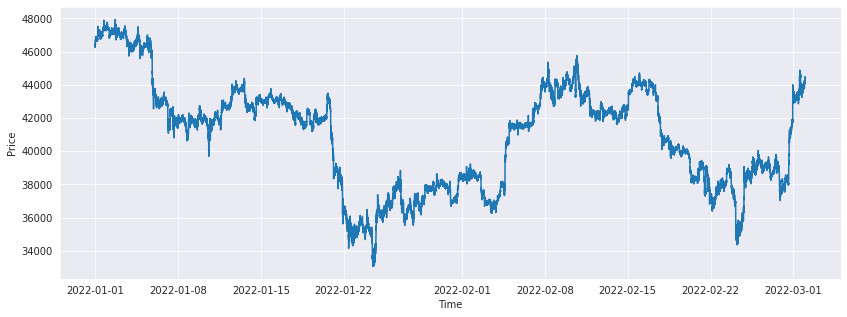

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(df[START_DATE:FINISH_DATE].index, df[START_DATE:FINISH_DATE]['close'])
ax.set_xlabel("Time")
ax.set_ylabel("Price")

In [7]:
df_train = df[START_DATE:FINISH_DATE][['open', 'high', 'low', 'close']].copy()
df_train[['open', 'high', 'low', 'close']] = df_train[['open', 'high', 'low', 'close']] - df_train[['open', 'high', 'low', 'close']].mean().mean()
df_train[['open', 'high', 'low', 'close']] = df_train[['open', 'high', 'low', 'close']] / df_train[['open', 'high', 'low', 'close']].std().mean()
df_train['price'] = df[START_DATE:FINISH_DATE]['close']

for period in PERIODS:
    df_train['open' + period] = df_train['open'].rolling(period).agg(lambda rows: rows[0])
    df_train['high' + period] = df_train['high'].rolling(period).max()
    df_train['low' + period] = df_train['low'].rolling(period).min()

In [8]:
df_train = df_train[INITIAL_DATE:]

## Environment

Let's implement a Gym environment, which RLlib can use.
A RLlib ready environment consist of three main parts, a constructor, a method to reset an environment, and a method for step.
- A constructor should specify action and observation spaces.
For action space we choose a continuous interval [-1, 1], where -1 means sell everything up to the base cash equivalent, 1 means buy an asset up to the base cash equivalent.
So an agent will be able to choose the amount of active it wants to buy or sell.
As a base cash we will use 10000 usdt, and a trading asset is bitcoin.
Thus, action -0.5 means sell bitcoins equivalent to 5000 usdt.
Observation space is a number of records in the observations array, which consist of one step candlestick data, plus 2 records for amount of usdt and bitcoin.
- A reset should return an initial state of environment. 
In our environment it is an array of candlesticks data for the first time step.
Also in a reset method we define the length of episode through initial and final steps.
We will use 2000 steps for this length.
1440 minutes equals a day, so 2000 steps is approximately a day and a half.
During training, environment will feed an agent with episodes of these period with a random initial step, so agent will receive diverse experience.
- A step should return the current state, a reward at the current step, and if environment is done.

In [ ]:
def prepare_dict(df):
    price_array = df['price'].to_numpy(dtype=np.float32)[:, np.newaxis]
    df = df.drop(columns=['price'])
    obs_array = df.to_numpy(dtype=np.float32)
    data_dictionary = {'price_array': price_array, 'observations': obs_array}
    return data_dictionary


class CryptoEnv(gym.Env):
    def __init__(self, config: EnvContext):
        self._price_array = config['price_array']
        self._observations = config['observations']

        self._base_cash = config['initial_capital']
        self._cash_usd = None
        self._stocks_usd = None
        self._stocks = None
        self._total_asset = None
        self._initial_total_asset = None

        self._time_step = None
        self._initial_step = None
        self._max_steps = config['max_steps']
        self._final_step = None
        self._upper_bound_step = self._price_array.shape[0] - self._max_steps - 1

        self._gamma = config['gamma']
        self._gamma_return = None

        self._action_dim = self._price_array.shape[1]
        # buy or sell up to the base cash equivalent(usd)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self._action_dim,), dtype=np.float32)
        # cash + stocks + observations
        self._state_dim = 2 + self._observations.shape[1]
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(self._state_dim,), dtype=np.float32)

        self._state = None
        self._episode_ended = None

    def reset(self):
        self._time_step = self._initial_step = random.randint(0, self._upper_bound_step)
        self._final_step = self._initial_step + self._max_steps
        self._cash_usd = random.random() * self._base_cash
        self._stocks_usd = random.random() * self._base_cash
        self._stocks = self._stocks_usd / self._price_array[self._time_step][0]
        self._total_asset = self._initial_total_asset = self._cash_usd + self._stocks_usd
        self._gamma_return = 0.0

        self._state = self._get_state()
        self._episode_ended = False
        return self._state

    def step(self, action):
        self._time_step += 1
        price = self._price_array[self._time_step][0]
        self._stocks_usd = self._stocks * price
        if action[0] < 0 and price > 0:  # sell
            sell_shares_usd = min(self._base_cash * -action[0], self._stocks_usd)
            self._stocks_usd -= sell_shares_usd
            self._cash_usd += sell_shares_usd
        elif action[0] > 0 and price > 0:  # buy
            money_to_spend = min(self._base_cash * action[0], self._cash_usd)
            self._stocks_usd += money_to_spend
            self._cash_usd -= money_to_spend
        self._stocks = self._stocks_usd / price

        self._episode_ended = self._time_step == self._final_step
        self._state = self._get_state()
        next_total_asset = self._cash_usd + self._stocks_usd

        reward = (next_total_asset - self._total_asset) / self._base_cash
        self._total_asset = next_total_asset
        self._gamma_return = self._gamma_return * self._gamma + reward
        if self._episode_ended:
            reward = self._gamma_return
            return self._state, reward, True, self._get_info()
        else:
            return self._state, reward, False, self._get_info()

    def _get_state(self):
        state = np.hstack(((self._cash_usd - self._base_cash) / self._base_cash, 
                           (self._stocks_usd - self._base_cash) / self._base_cash))
        observation = self._observations[self._time_step]
        state = np.hstack((state, observation)).astype(np.float32)
        return state

    def _get_info(self):
        return {"Initial step": self._initial_step, 
                "Final step": self._final_step, 
                "Initial total asset": self._initial_total_asset, 
                "Final total asset": self._total_asset, 
                "Gamma return": self._gamma_return}

## Train agent

In [9]:
stop_iters = 200
n_workers = 1
n_envs_per_worker = 100
r_fragment_length = 2000
train_batch_size = n_workers * n_envs_per_worker * r_fragment_length
sgd_minibatch_size = int(train_batch_size / 10)
train_dict = prepare_dict(df_train)
config = {
    "env": CryptoEnv,
    "env_config": {
        "price_array": train_dict['price_array'],
        "observations": train_dict['observations'],
        "initial_capital": 1e4,
        "gamma": 0.99,
        "max_steps": r_fragment_length,
    },
    "num_gpus": 1,
    "model": {
        "vf_share_layers": False,
    },
    "num_workers": n_workers,
    "num_envs_per_worker": n_envs_per_worker,
    "rollout_fragment_length": r_fragment_length,
    "train_batch_size": train_batch_size,
    "sgd_minibatch_size": sgd_minibatch_size,
    "batch_mode": "complete_episodes",
    "framework": "tf",
}

In [10]:
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(config)
ppo_config["lr"] = 1e-5
trainer = ppo.PPOTrainer(config=ppo_config, env=CryptoEnv)
for iter in range(stop_iters):
    result = trainer.train()
    # print(f"Iteration {iter}.", end ="\r")
    print(f"Iteration {iter}.")

2022-05-29 05:48:12,518	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=450) 2022-05-29 05:48:18,466	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=450) 2022-05-29 05:48:18,466	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=450) 2022-05-29 05:48:19,603	WARNING rollout_worker.py:1747 -- We've added a module for checking environments that are used 

Iteration 0.
Iteration 1.
Iteration 2.
Iteration 3.
Iteration 4.
Iteration 5.
Iteration 6.
Iteration 7.
Iteration 8.
Iteration 9.
Iteration 10.
Iteration 11.
Iteration 12.
Iteration 13.
Iteration 14.
Iteration 15.
Iteration 16.
Iteration 17.
Iteration 18.
Iteration 19.
Iteration 20.
Iteration 21.
Iteration 22.
Iteration 23.
Iteration 24.
Iteration 25.
Iteration 26.
Iteration 27.
Iteration 28.
Iteration 29.
Iteration 30.
Iteration 31.
Iteration 32.
Iteration 33.
Iteration 34.
Iteration 35.
Iteration 36.
Iteration 37.
Iteration 38.
Iteration 39.
Iteration 40.
Iteration 41.
Iteration 42.
Iteration 43.
Iteration 44.
Iteration 45.
Iteration 46.
Iteration 47.
Iteration 48.
Iteration 49.
Iteration 50.
Iteration 51.
Iteration 52.
Iteration 53.
Iteration 54.
Iteration 55.
Iteration 56.
Iteration 57.
Iteration 58.
Iteration 59.
Iteration 60.
Iteration 61.
Iteration 62.
Iteration 63.
Iteration 64.
Iteration 65.
Iteration 66.
Iteration 67.
Iteration 68.
Iteration 69.
Iteration 70.
Iteration 71.
It

## Visualize results 

In [11]:
config["env_config"]["max_steps"] = df_train.shape[0] - 1
env = CryptoEnv(config["env_config"])
actions = []
total_assets = []
rewards = []
observation = env.reset()
while True:
    action = trainer.compute_action(observation)
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    total_assets.append(info["Final total asset"])
    actions.append(action)
    if done:
        break

2022-05-29 07:51:23,806	WARNING deprecation.py:47 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


In [ ]:
init_step, final_step = info["Initial step"], info["Final step"]

Text(0.5, 1.0, 'Train set')

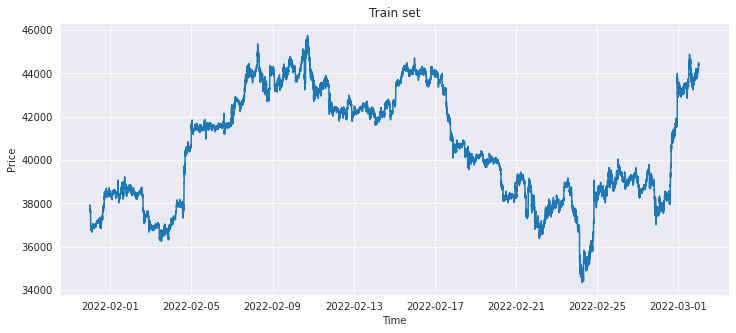

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(df_train.iloc[init_step: final_step].index, df_train.iloc[init_step: final_step]['price'])
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.set_title("Train set")

Text(0, 0.5, 'Total asset')

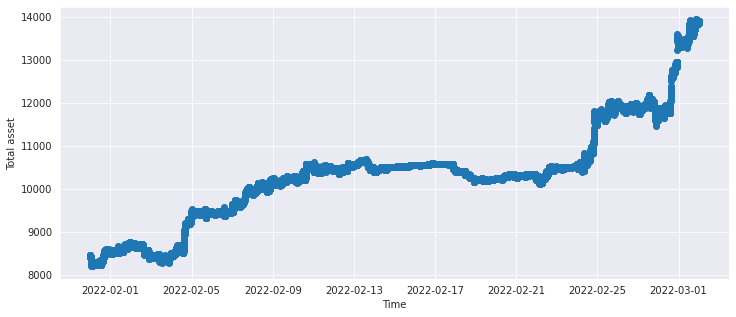

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(df_train.iloc[init_step: final_step].index, np.array(total_assets))
ax.set_xlabel("Time")
ax.set_ylabel("Total asset")